In [1]:
import kagglehub
rtatman_glove_global_vectors_for_word_representation_path = kagglehub.dataset_download('rtatman/glove-global-vectors-for-word-representation')
vbmokin_nlp_with_disaster_tweets_cleaning_data_path = kagglehub.dataset_download('vbmokin/nlp-with-disaster-tweets-cleaning-data')

print('Data source import complete.')

100%|██████████| 458M/458M [00:03<00:00, 146MB/s]

Extracting files...


100%|██████████| 1.00M/1.00M [00:00<00:00, 68.4MB/s]

Extracting files...
Data source import complete.


# New section

In [2]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatib

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm


import torch

import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Download Data

In [6]:
import pandas as pd

# train_df = pd.read_csv('/kaggle/input/nlp-with-disaster-tweets-cleaning-data/train_data_cleaning.csv')
# test_df = pd.read_csv('/kaggle/input/nlp-with-disaster-tweets-cleaning-data/test_data_cleaning.csv')
tweet= pd.read_csv('../content/input/train.csv')
test=pd.read_csv('../content/input/test.csv')
submission = pd.read_csv("../content/input/sample_submission.csv")
# Preview
# print(train_df.head())

In [7]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


In [8]:
tweet.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


## EDA

#### Class Distribution

In [10]:
# extracting the number of examples of each class
Real_len = tweet[tweet['target'] == 1].shape[0]
Not_len = tweet[tweet['target'] == 0].shape[0]

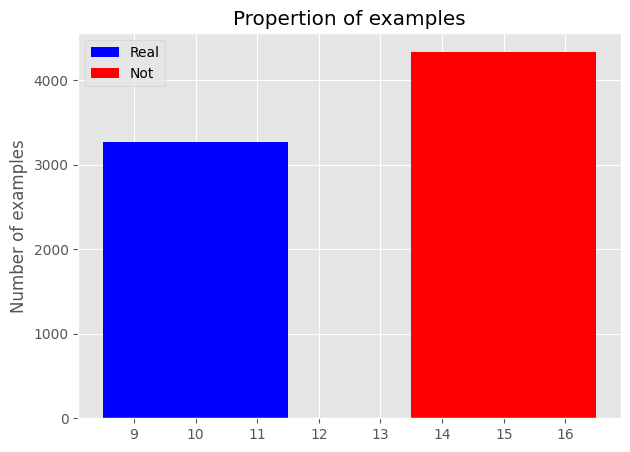

In [11]:
# bar plot of the 3 classes
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real_len,3, label="Real", color='blue')
plt.bar(15,Not_len,3, label="Not", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

#### Number of characters in tweets

In [12]:
def length(text):
    '''a function which returns the length of text'''
    return len(text)

In [13]:
tweet['length'] = tweet['text'].apply(length)

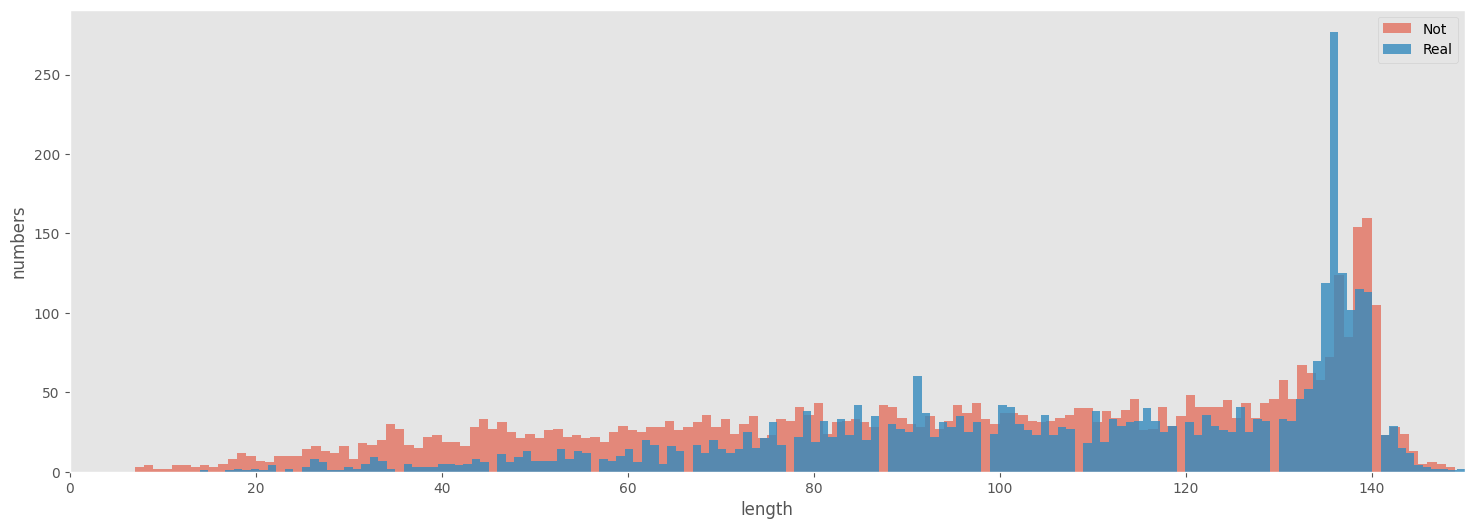

In [14]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(tweet[tweet['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Not')
plt.hist(tweet[tweet['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

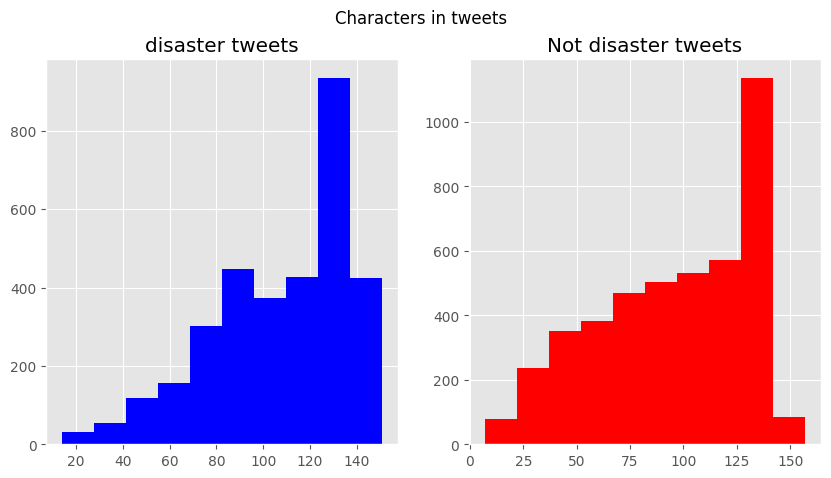

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

The distribution of both seems to be almost same, 120 to 140 characters in a tweet are the most common among both.

#### Number of words in a tweet

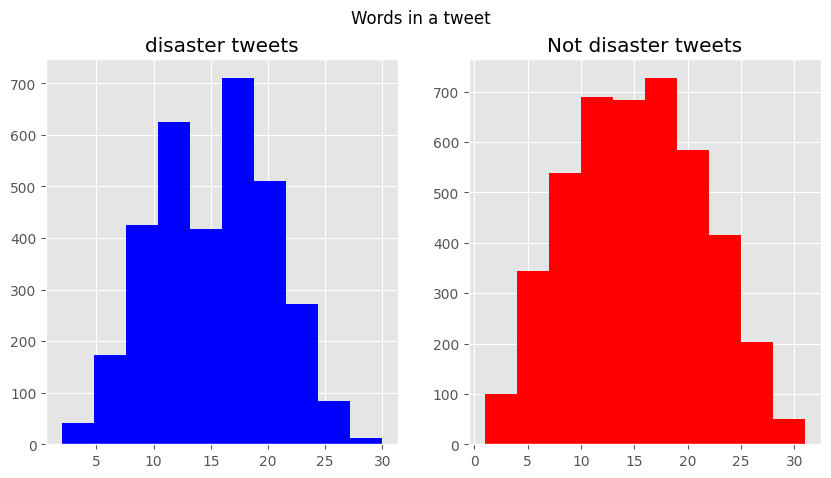

In [16]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

#### Average word length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

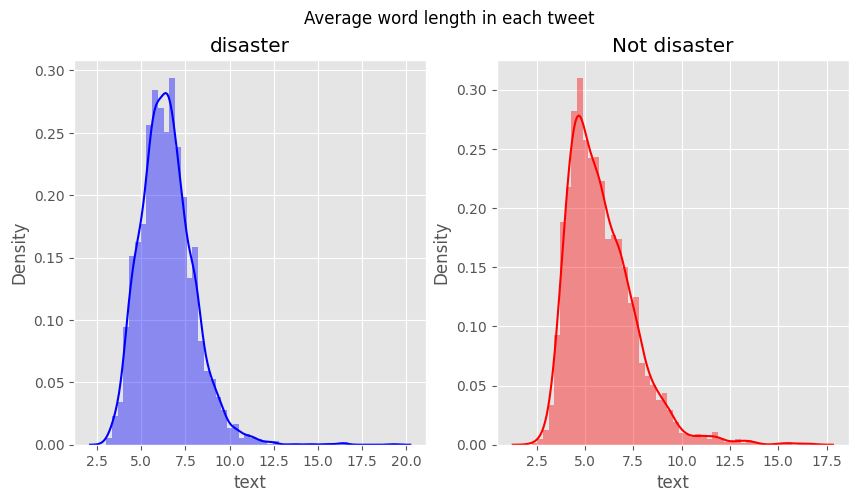

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

#### Creating Corpus

In [18]:
def create_corpus(target):
    corpus=[]

    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [19]:
def create_corpus_df(tweet, target):
    corpus=[]

    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

### Common stopwords in tweets

First we will analyze tweets with class 0.

In [20]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

In [21]:
# displaying the stopwords
np.array(stop)

array({'once', 'your', 'as', "needn't", "they'll", "should've", "they'd", 'are', 'it', "mustn't", "you'll", "don't", "i'm", 'not', 'yourself', "he's", "you've", 'myself', 'over', 'is', 'other', 'mightn', 'my', 'hasn', 'won', 'isn', 'because', 'on', 'after', 'don', 'couldn', 'about', 'd', 'himself', "isn't", "it's", 'more', 'do', 'that', 'has', 'most', 'aren', "hadn't", 'some', "we'd", "you're", 'a', 'which', 'me', 'we', 'own', "hasn't", 'out', "they're", 'will', 't', 'she', 'does', 'her', 'again', 'theirs', 'doesn', 'but', "mightn't", 'having', "he'll", 'him', 'have', "she'd", "they've", "that'll", 'during', 'just', 'our', 'so', 'been', 'both', "i'd", 'its', 'them', 'until', 'herself', 'where', 'while', "wasn't", 'if', 'mustn', 'ours', 'were', 'further', 'now', 'they', 'his', 'why', 'below', 'down', 'themselves', 'be', 'weren', 'with', 'off', "it'll", 'ourselves', "i'll", 'few', "won't", 'very', "wouldn't", 'an', 'll', "we'll", 'he', 'ma', 'was', 'whom', 'i', 'itself', "doesn't", 'from

<BarContainer object of 10 artists>

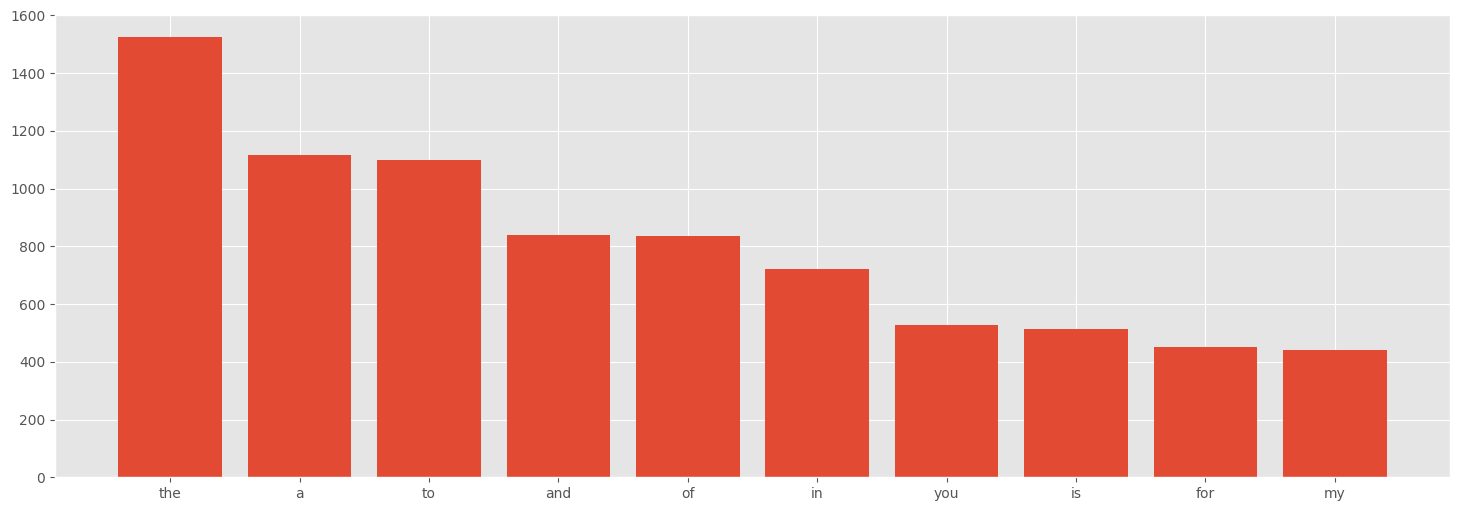

In [22]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

Now,we will analyze tweets with class 1.

<BarContainer object of 10 artists>

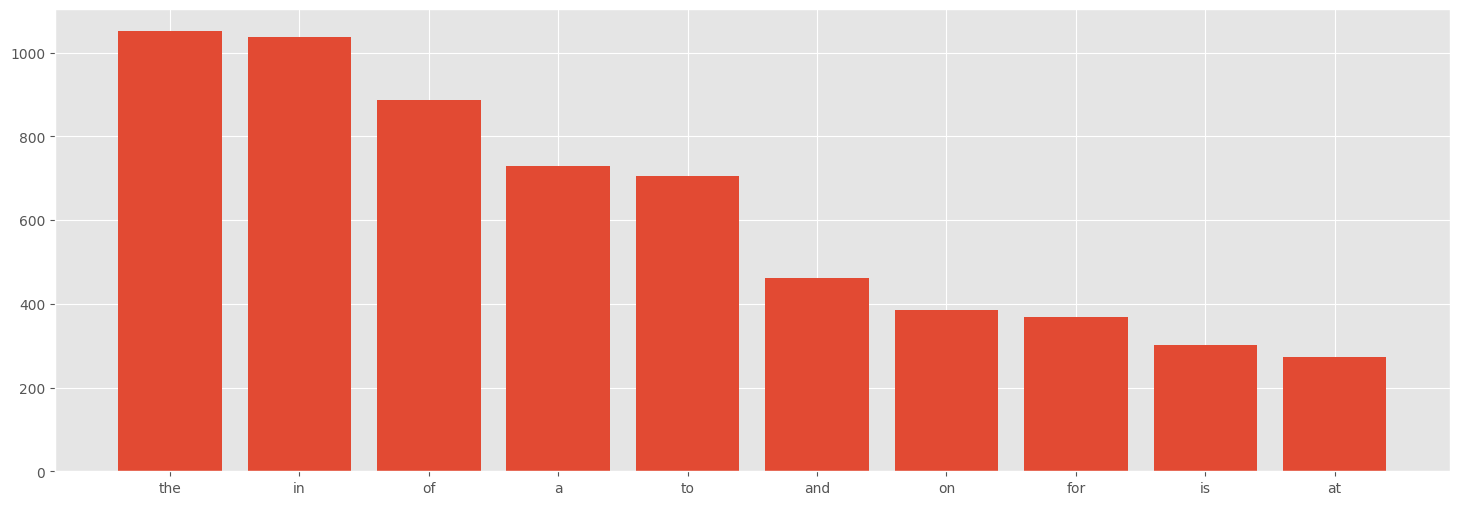

In [23]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]


plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

In both of them,"the" dominates which is followed by "a" in class 0 and "in" in class 1.

## Analyzing punctuations

First let's check tweets indicating real disaster.

<BarContainer object of 18 artists>

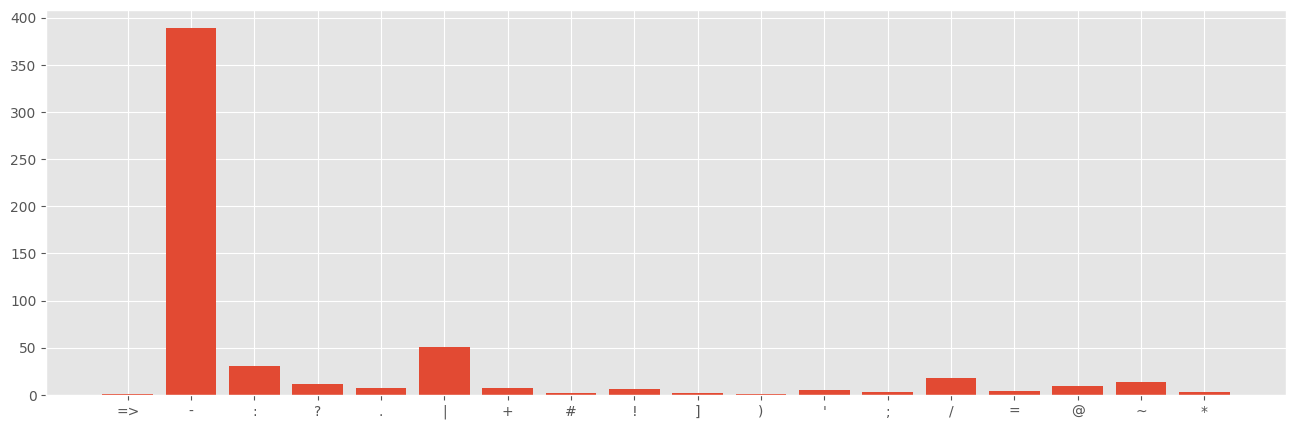

In [24]:
plt.figure(figsize=(16,5))
corpus=create_corpus(1)

dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

x,y=zip(*dic.items())
plt.bar(x,y)

Now,we will move on to class 0.

<BarContainer object of 20 artists>

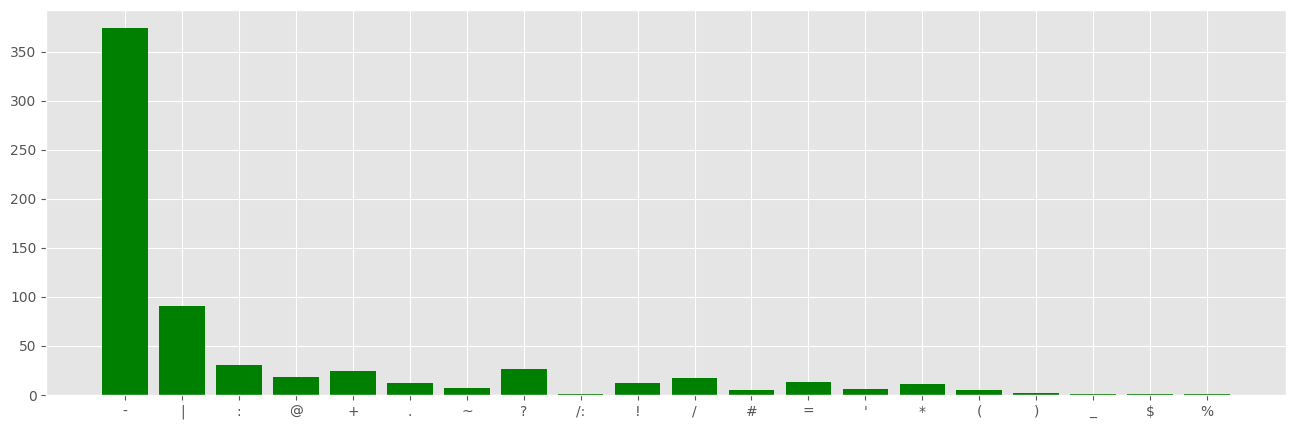

In [25]:
plt.figure(figsize=(16,5))
corpus=create_corpus(0)
dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

x,y=zip(*dic.items())
plt.bar(x,y,color='green')

### Common words

In [26]:
plt.figure(figsize=(16,5))
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

<Figure size 1600x500 with 0 Axes>

<Axes: >

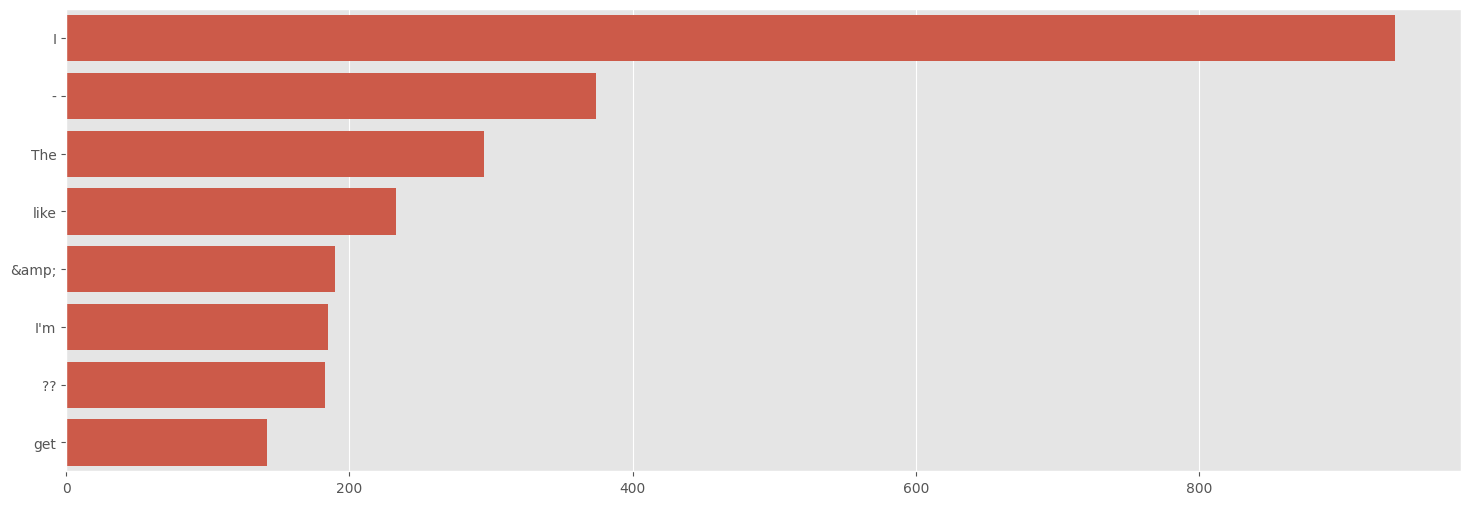

In [27]:
sns.barplot(x=y,y=x)

### BiGram Analysis

In [28]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

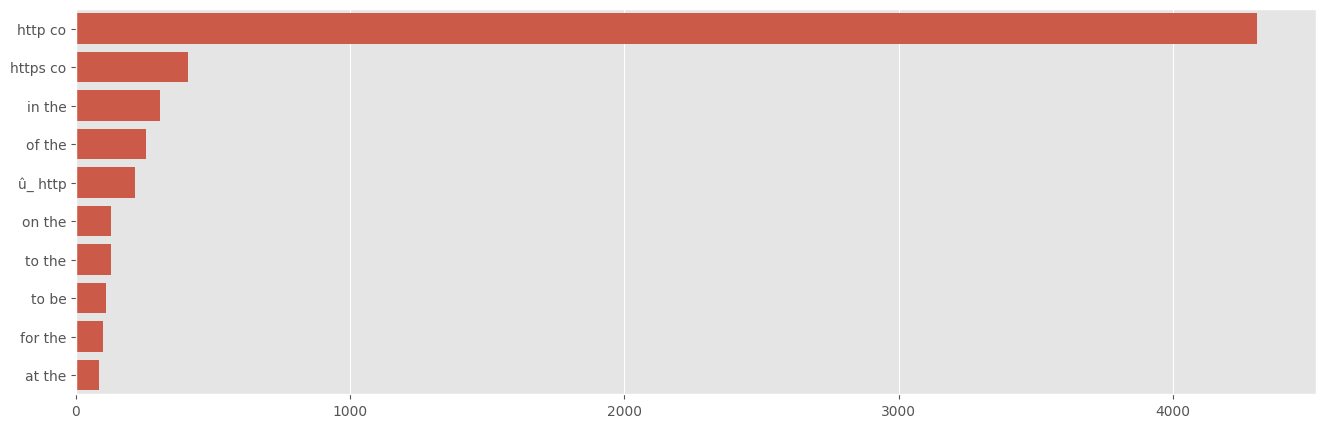

In [29]:
plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

## Data Cleaning

In [30]:
df=pd.concat([tweet,test])
df.shape

(10876, 6)

### Removing URLs

In [31]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [32]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [33]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

 ### Removing HTML tags

In [34]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [35]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [36]:
df['text']=df['text'].apply(lambda x : remove_html(x))

### Removing Emojis

In [37]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [38]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

### Removing punctuations

In [39]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [40]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

## WordCloud

### Real Disaster

In [41]:
corpus_new1=create_corpus_df(df,1)
len(corpus_new1)

46269

In [42]:
corpus_new1[:10]

['Our',
 'Deeds',
 'are',
 'the',
 'Reason',
 'of',
 'this',
 'earthquake',
 'May',
 'ALLAH']

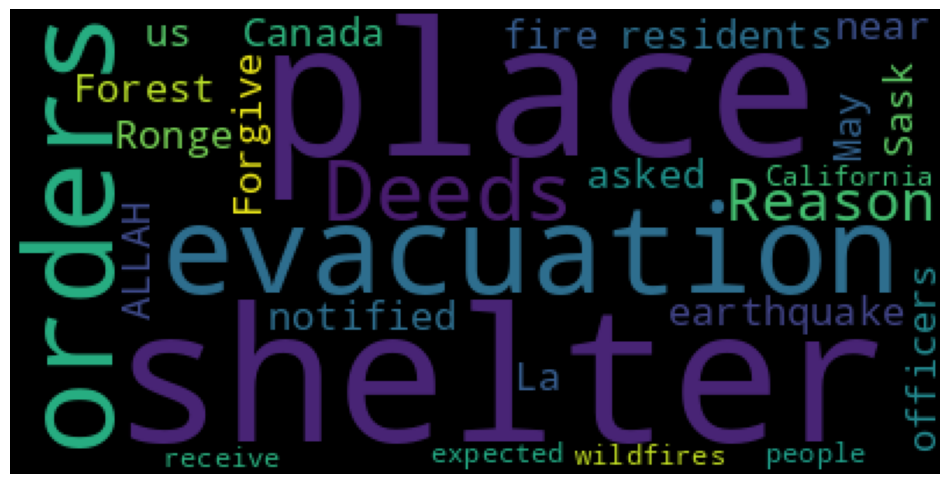

In [43]:
# Generating the wordcloud with the values under the category dataframe
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new1[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### Not Disaster

In [44]:
corpus_new0=create_corpus_df(df,0)
len(corpus_new0)

60478

In [45]:
corpus_new0[:10]

['Whats', 'up', 'man', 'I', 'love', 'fruits', 'Summer', 'is', 'lovely', 'My']

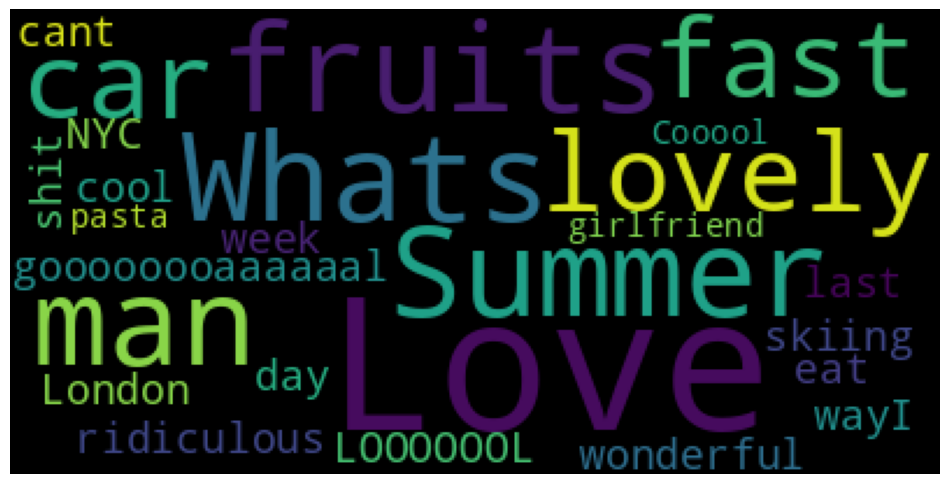

In [46]:
# Generating the wordcloud with the values under the category dataframe
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new0[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Bag of Words Counts

In [49]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = df["text"].tolist()
list_labels = df["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2,
                                                                                random_state=42)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Visualizing the embeddings

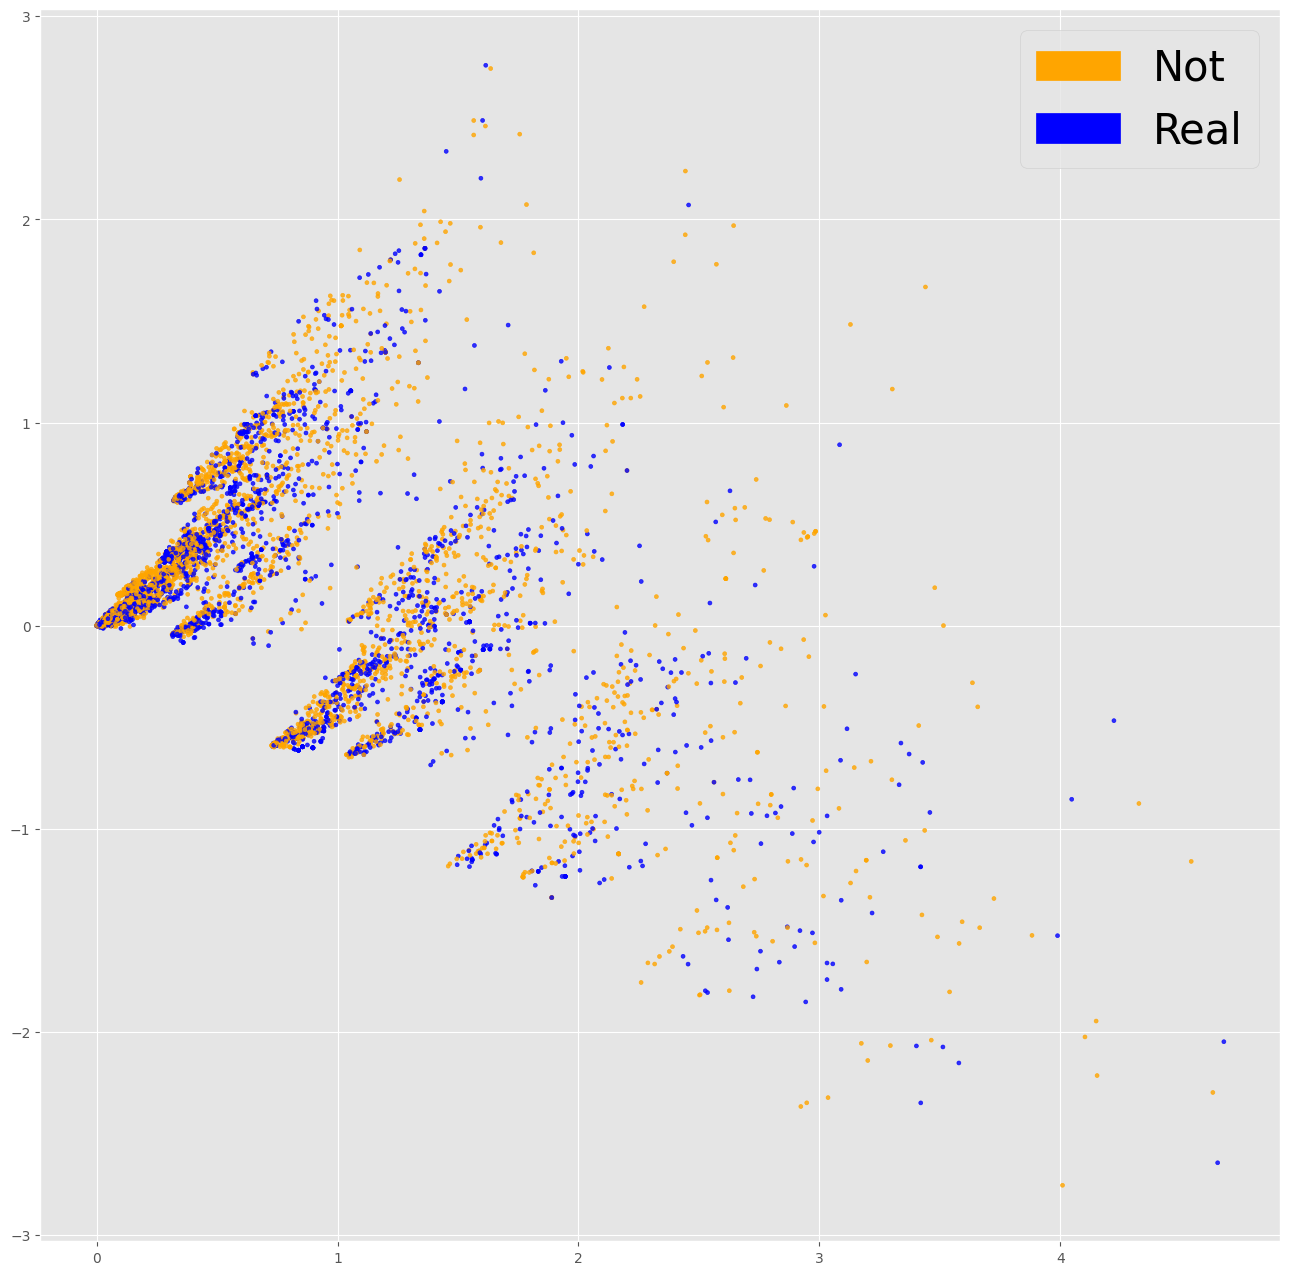

In [50]:
## REIVEW

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_counts, y_train)
plt.show()

## TF-IDF

In [51]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

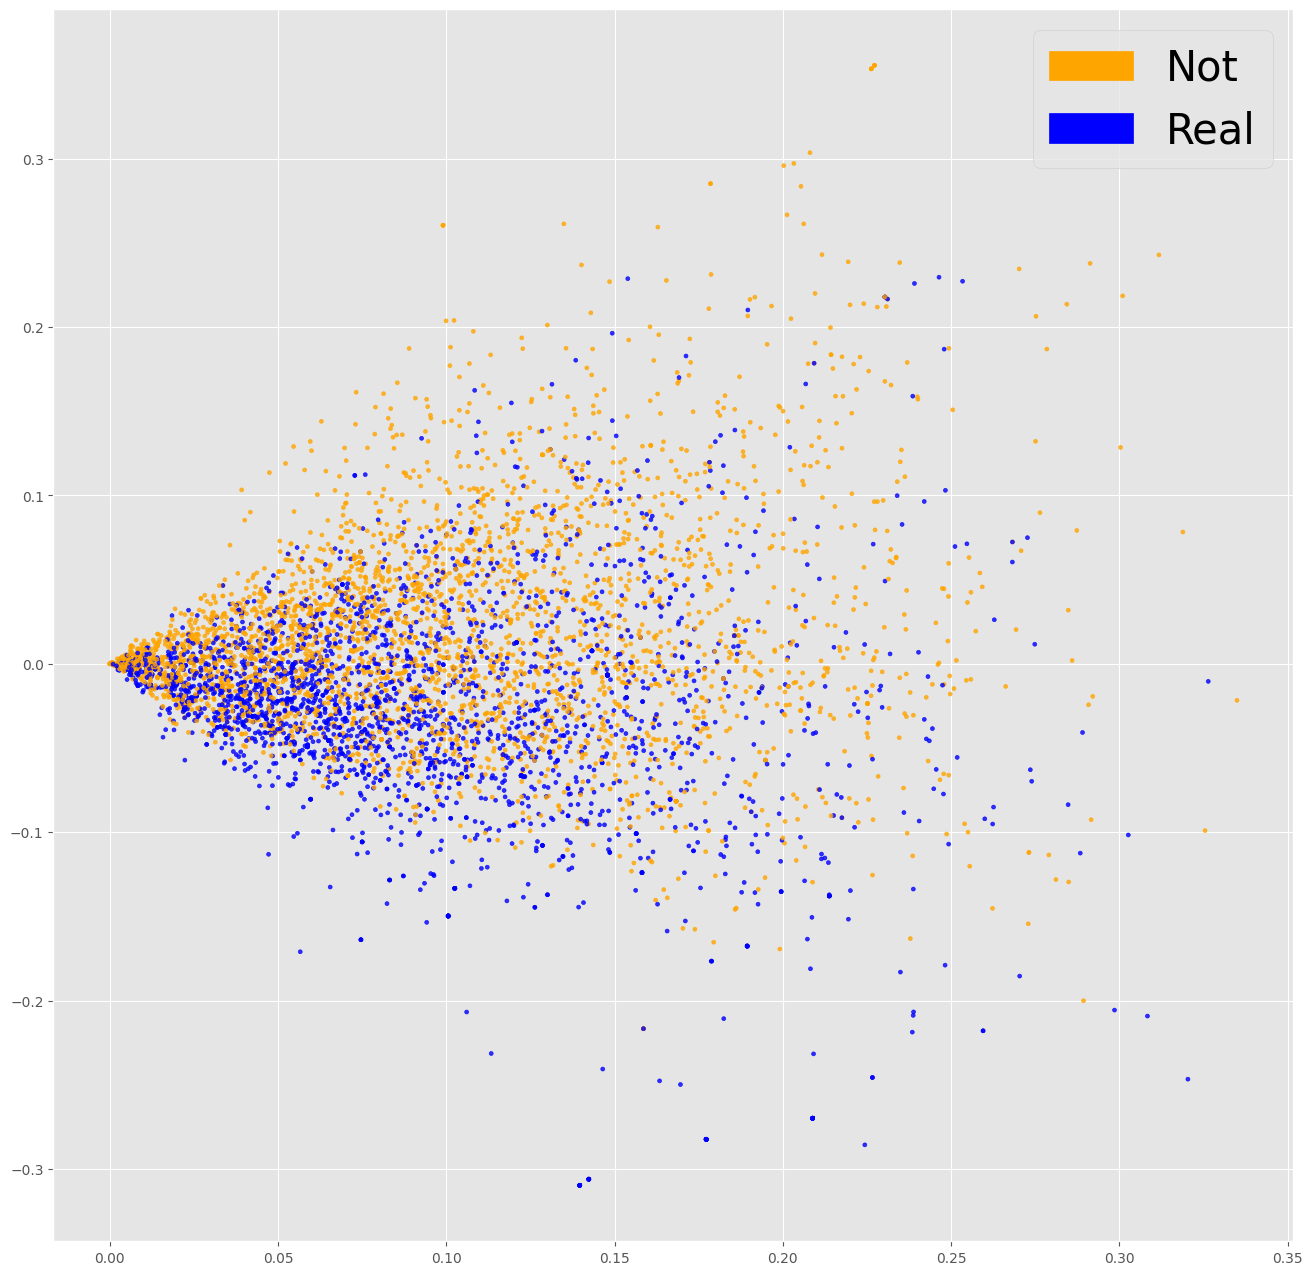

In [52]:
## REVIEW

fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_tfidf, y_train)
plt.show()